In [7]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset


DAYS_FOR_TRAIN = 3
FEATURE_SIZE = 6
BATCH_SIZE = 32
TEST_SIZE = 0.3
DROPOUT_PROB = 0.2

# torch.manual_seed(0)

In [17]:
def my_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
#     extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(ori_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


class StockDataset(Dataset):
    """stock market dataset"""
    
    def __init__(self, dataset, days_for_train=5, feature_size=5, scaled=True, scaler=None):
        self.days_for_train = days_for_train
        self.feature_size = feature_size
        self.ori_data = dataset

        self.data = self.ori_data.iloc[:, 1:1+self.feature_size].values.astype(np.float32)

        if scaled:
            if scaler is None:
                self.scaler = MinMaxScaler()
                self.data = self.scaler.fit_transform(self.data).astype(np.float32)
            else:
                self.data = scaler.transform(self.data).astype(np.float32)
                self.scaler = scaler
        
        self.x = self.data
        self.y = self.data[:, 3]
        

    def __len__(self):
        return self.data.shape[0] - self.days_for_train

    
    def __getitem__(self, idx):
        x = self.x[idx:idx+self.days_for_train]
        y = np.zeros((1), dtype=np.float32)

        y[0] = self.y[idx+self.days_for_train]

        t_x = torch.from_numpy(x)
        t_y = torch.from_numpy(y)
        return t_x, t_y
    
    def get_scaler(self):
        return self.scaler


class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)

    def forward(self, _x):
        out0 = self.fc0(_x)
        x, _ = self.lstm(out0)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        out1 = self.fc(x)
        out1 = out1.view(s, b)  # 把形状改回来
        out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
        out2 = self.fc2(out1)
        # print(out2.shape)
        # out2 = out2.view(b, -1)
        return out2
    

def my_train(train_dataset):
#     print(train_dataset)
    data = StockDataset(train_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE)
    D = DataLoader(dataset=data, batch_size=BATCH_SIZE)

    model = LSTM_Regression(FEATURE_SIZE, 8, output_size=1, num_layers=2)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(500):       
        for i, (x, y) in enumerate(D):
#             print(x.shape, y.shape)
            x = x.transpose(0, 1)
#             x.transpose(1, 2)
            pred_y = model(x)
#             print('pred_y: ', pred_y.shape)
            loss = loss_function(pred_y, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # out = model(train_x)
        # loss = loss_function(out, train_y)

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

        if (epoch+1) % 20 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))
    
    return model, data.scaler


In [18]:
train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')

In [19]:
trained_model, train_scaler = my_train(train_dataset)

Epoch: 20, Loss:0.19729
Epoch: 40, Loss:0.10810
Epoch: 60, Loss:0.01670
Epoch: 80, Loss:0.01217
Epoch: 100, Loss:0.00935
Epoch: 120, Loss:0.00775
Epoch: 140, Loss:0.00791
Epoch: 160, Loss:0.00814
Epoch: 180, Loss:0.00779
Epoch: 200, Loss:0.00399
Epoch: 220, Loss:0.00440
Epoch: 240, Loss:0.00518
Epoch: 260, Loss:0.00451
Epoch: 280, Loss:0.00364
Epoch: 300, Loss:0.00349
Epoch: 320, Loss:0.00562
Epoch: 340, Loss:0.00397
Epoch: 360, Loss:0.00336
Epoch: 380, Loss:0.00291
Epoch: 400, Loss:0.00384
Epoch: 420, Loss:0.00427
Epoch: 440, Loss:0.00312
Epoch: 460, Loss:0.00313
Epoch: 480, Loss:0.00574
Epoch: 500, Loss:0.00551


In [20]:
def my_test(model, test_dataset, train_scaler):
    model.eval()
    loss_function = nn.MSELoss()

    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
    test_D = DataLoader(dataset=test_data, batch_size=1)

    all_loss = []
    preds = []
    targets = []

    for i, (test_x, test_y) in enumerate(test_D):
        test_x = test_x.transpose(0, 1)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
        preds.extend(pred_y.detach().numpy())
        targets.extend(test_y.detach().numpy())

        test_loss = loss_function(pred_y, test_y)
        all_loss.append(test_loss)
#         print(test_loss)

    print('test loss: %.5f' % (sum(all_loss)))
    
    train_size = len(test_data) * (1 - TEST_SIZE)
    plt.plot(preds, 'r', label='prediction')
    plt.plot(targets, 'b', label='real')
    plt.plot((train_size, train_size), (-0.1, 1.5), 'g--')
    plt.savefig('result_img/result.png', format='png', dpi=200)
    plt.show()

test loss: 1.46547


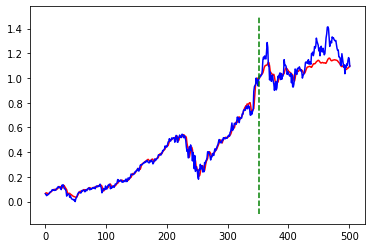

In [21]:
my_test(trained_model, ori_dataset, train_scaler)